In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import pandas as pd
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt
from timm import create_model
import numpy as np

# Define the dataset class
class AUDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.data['fname'] = self.data['fname'].astype(str)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.data.iloc[idx]['fname'])
        image = Image.open(img_name).convert("RGB")
        labels = torch.tensor(self.data.iloc[idx, 3:].values.astype('float32'))  # Assuming label columns start from index 1

        if self.transform:
            image = self.transform(image)

        return image, labels

# Define the model using Vision Transformer (DeiT) with dropout
class AUModel(nn.Module):
    def __init__(self, num_aus, dropout_rate=0.5):
        super(AUModel, self).__init__()
        self.base_model = create_model('deit_small_patch16_224', pretrained=True)

        # Add dropout before the final layer
        self.dropout = nn.Dropout(dropout_rate)
        self.base_model.head = nn.Linear(self.base_model.head.in_features, num_aus)

    def forward(self, x):
        x = self.base_model.forward_features(x)
        x = self.base_model.forward_head(x, pre_logits=True)
        x = self.dropout(x)
        x = self.base_model.head(x)
        return x

# Training function
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs=6):  # Changed to 6 epochs
    best_val_f1 = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_preds, train_labels = 0, [], []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_f1 = f1_score(np.array(train_labels) > 0.5, np.array(train_preds) > 0.5, average='macro')

        # Validation phase
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(np.array(val_labels) > 0.5, np.array(val_preds) > 0.5, average='macro')

        # Test phase
        test_preds, test_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                test_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        test_f1 = f1_score(np.array(test_labels) > 0.5, np.array(test_preds) > 0.5, average='macro')

        print(f"Epoch {epoch+1}/{num_epochs}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}")

        # Save best model based on validation F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)
    return model

# Confusion matrix display function
def plot_confusion_matrix(true_labels, predictions, classes):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# File paths
train_csv_files = [
    'drive/My Drive/TIF/train_new/TIF_AUG_AU_SI_ver1_fold_0.csv',
    'drive/My Drive/TIF/train_new/TIF_AUG_AU_SI_ver1_fold_1.csv',
    'drive/My Drive/TIF/train_new/TIF_AUG_AU_SI_ver1_fold_2.csv',
]
test_csv_files = [
    'drive/My Drive/TIF/val_new/TIF_AUG_AU_SI_ver1_fold_0.csv',
    'drive/My Drive/TIF/val_new/TIF_AUG_AU_SI_ver1_fold_1.csv',
    'drive/My Drive/TIF/val_new/TIF_AUG_AU_SI_ver1_fold_2.csv',
]
image_dir = 'drive/My Drive/TIF/CroppedFromPhotos/TIF_DB_Augmented'

# Define Action Unit columns
au_columns = ['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20']
num_aus = len(au_columns)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loss function and device
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
best_model = None
all_predictions = []

# Iterate through each train-test pair
for train_csv, test_csv in zip(train_csv_files, test_csv_files):
    # Create datasets
    full_train_dataset = AUDataset(train_csv, image_dir, transform=transform)
    test_dataset = AUDataset(test_csv, image_dir, transform=transform)

    # Split train dataset into train and validation sets
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize the Vision Transformer model with dropout
    model = AUModel(num_aus, dropout_rate=0.5).to(device)  # Added dropout with rate 0.5
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train the model for 6 epochs
    model = train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs=1)

    # Evaluate on the test dataset
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs))
            test_preds.extend(outputs.cpu().numpy() > 0.5)
            test_labels.extend(labels.cpu().numpy())

    # Save predictions
    fold_predictions = pd.DataFrame(test_preds, columns=au_columns)
    fold_predictions['fname'] = test_dataset.data['fname'].values[:len(test_preds)]
    all_predictions.append(fold_predictions)





/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch 1/1, Train F1: 0.4185, Val F1: 0.5425, Test F1: 0.4139
Epoch 1/1, Train F1: 0.4165, Val F1: 0.5078, Test F1: 0.3935
Epoch 1/1, Train F1: 0.3299, Val F1: 0.4328, Test F1: 0.4403


NameError: name 'final_predictions' is not defined

In [ ]:
# Combine and save all predictions
final_predictions = pd.concat(all_predictions, ignore_index=True)
final_predictions.to_csv('all_test_predictions_with_val.csv', index=False)
print(f"Total predictions saved: {len(final_predictions)}")
print(final_predictions.head())  # İlk birkaç satırı kontrol et
print("Training complete. Predictions saved to all_test_predictions_with_val_5.csv")

Total predictions saved: 1170
     AU1    AU2   AU3   AU4   AU6    AU9   AU12  AU20  \
0   True  False  True  True  True  False  False  True   
1   True  False  True  True  True  False  False  True   
2  False  False  True  True  True  False  False  True   
3  False  False  True  True  True  False  False  True   
4   True  False  True  True  True  False  False  True   

                       fname  
0  A04M6-JTP-4669SA-DI_0.png  
1  A04M6-JTP-4669SA-DI_1.png  
2  A04M6-JTP-4669SA-DI_2.png  
3  A04M6-JTP-4669SA-DI_3.png  
4  A04M6-JTP-4669SA-DI_4.png  
Training complete. Predictions saved to all_test_predictions_with_val_5.csv


In [ ]:
!pip install Pillow

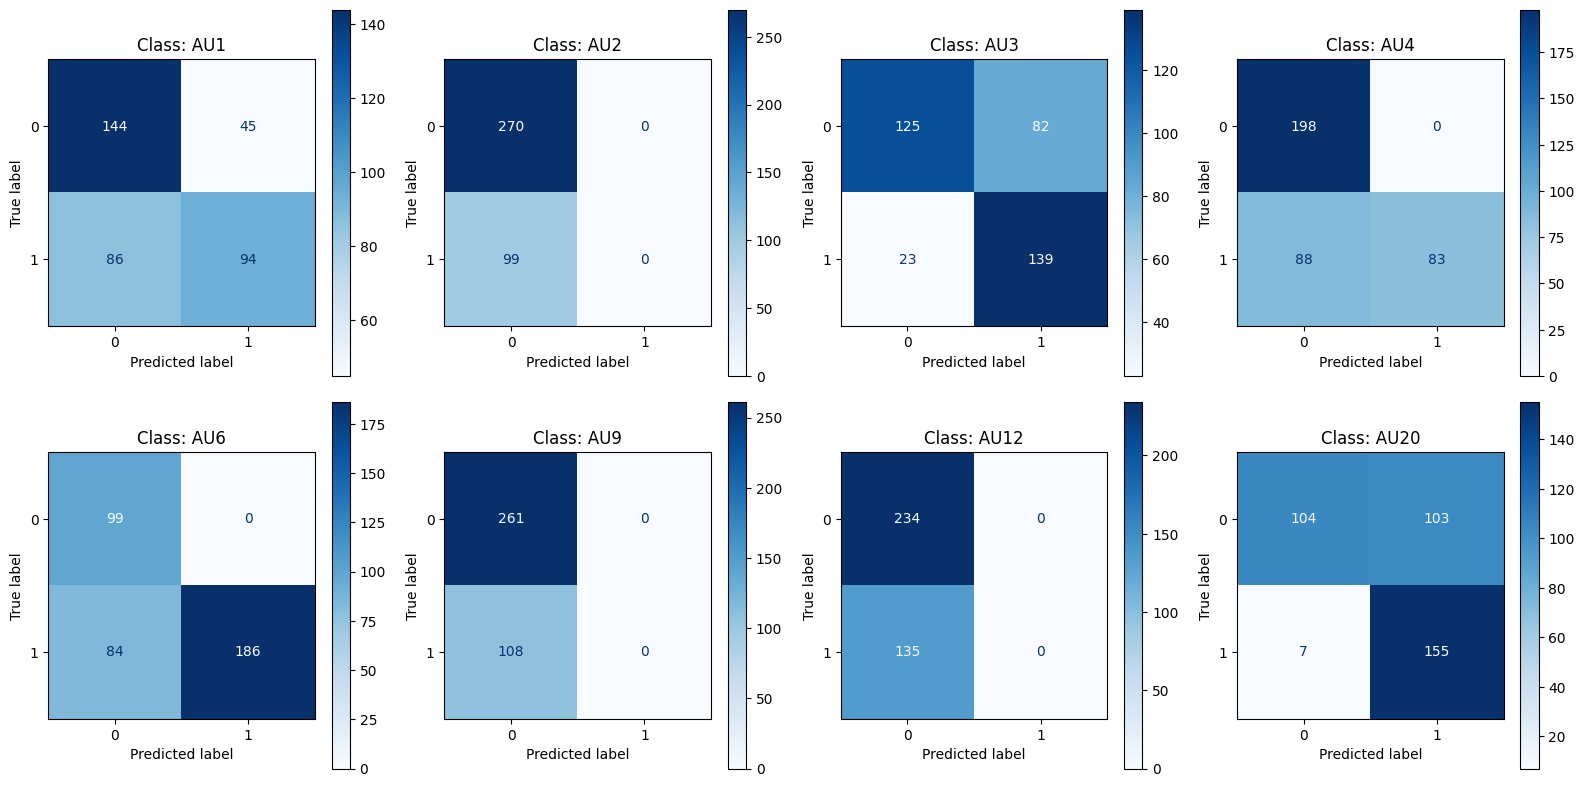

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

# Confusion matrix display function for subplot
def plot_confusion_matrix_subplot(true_labels, predictions, classes, ax):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Confusion Matrix')

# Test phase to collect predictions and true labels
test_preds, test_labels = [], []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs))  # Sigmoid output for multi-label classification
        preds = (outputs > 0.5).cpu().numpy()  # Apply threshold of 0.5 for binary classification

        # Collect predictions and true labels
        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays for sklearn compatibility
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

# Set up subplot grid (4 columns)
num_classes = test_preds.shape[1]
ncols = 4
nrows = (num_classes + ncols - 1) // ncols  # Calculate number of rows needed

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 4))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Plot confusion matrices in subplots
for i in range(num_classes):
    ax = axes[i]
    plot_confusion_matrix_subplot(test_labels[:, i], test_preds[:, i], classes=[0, 1], ax=ax)

    # Adjust titles for each subplot
    ax.set_title(f'Class: {au_columns[i]}')

# Remove any unused subplots
for j in range(num_classes, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Compute metrics for each Action Unit (AU)
results = []  # To store metrics for each AU

for i in range(test_preds.shape[1]):  # Loop through each AU
    true_positive = np.sum((test_labels[:, i] == 1) & (test_preds[:, i] == 1))  # True positives
    false_positive = np.sum((test_labels[:, i] == 0) & (test_preds[:, i] == 1))  # False positives
    false_negative = np.sum((test_labels[:, i] == 1) & (test_preds[:, i] == 0))  # False negatives
    true_negative = np.sum((test_labels[:, i] == 0) & (test_preds[:, i] == 0))  # True negatives

    total_samples = true_positive + false_positive + false_negative + true_negative  # Total samples for the AU

    # Calculate Recall (True Positive Rate)
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    results.append({
        "AU": au_columns[i],
        "Total Samples": total_samples,
        "Correctly Predicted": true_positive + true_negative,
        "Wrong Prediction": false_positive + false_negative,
        "Recall (%)": recall * 100  # Recall as a percentage
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the results as a table
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv("AU_metrics_total.csv", index=False)

     AU  Total Samples  Correctly Predicted  Wrong Prediction  Recall (%)
0   AU1            369                  238               131   52.222222
1   AU2            369                  270                99    0.000000
2   AU3            369                  264               105   85.802469
3   AU4            369                  281                88   48.538012
4   AU6            369                  285                84   68.888889
5   AU9            369                  261               108    0.000000
6  AU12            369                  234               135    0.000000
7  AU20            369                  259               110   95.679012


In [ ]:
from sklearn.metrics import f1_score

# Convert to numpy arrays and apply threshold
test_labels_array = np.array(test_labels) > 0.5
test_preds_array = np.array(test_preds) > 0.5

# Calculate overall F1 score (macro-average across all AUs)
overall_f1 = f1_score(test_labels_array, test_preds_array, average='macro')

# Display the overall F1 score
print(f"Overall F1 Score (Macro-Average): {overall_f1:.4f}")

Overall F1 Score (Macro-Average): 0.4403


In [ ]:
import pandas as pd

# Train CSV dosyalarının yollarını listeleyin
train_csv_files = [
    'drive/My Drive/TIF/train_new/TIF_AUG_AU_SI_ver1_fold_0.csv',
    'drive/My Drive/TIF/train_new/TIF_AUG_AU_SI_ver1_fold_1.csv',
    'drive/My Drive/TIF/train_new/TIF_AUG_AU_SI_ver1_fold_2.csv',
]

# Tüm CSV'leri birleştirin

train_data = pd.concat([pd.read_csv(csv_file) for csv_file in train_csv_files], ignore_index=True)

# Duplike satırları kaldırın
train_data_cleaned = train_data.drop_duplicates()

# Yeni temizlenmiş veriyi kaydedin
train_data_cleaned.to_csv('combined_train_data_tif.csv', index=False)

print(f"Orijinal veri sayısı: {len(train_data)}, Temizlenmiş veri sayısı: {len(train_data_cleaned)}")


Orijinal veri sayısı: 2340, Temizlenmiş veri sayısı: 1170


In [ ]:
pred = pd.read_csv("all_test_predictions_with_val.csv")
actual = pd.read_csv("combined_train_data_tif.csv")
pred = pred.replace({True: 1, False: 0})
columns = ['fname'] + [col for col in pred.columns if col != 'fname']
pred = pred[columns]
pred.to_csv('pred.csv', index=False)

<ipython-input-7-ce5656259ed3>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pred = pred.replace({True: 1, False: 0})


In [ ]:
predictions = pd.read_csv("pred.csv")
common_rows = pd.merge(predictions, actual)
print(f"Common rows: {len(common_rows)}")

Common rows: 99


In [ ]:
import pandas as pd

# Train CSV dosyalarının yollarını listeleyin
train_csv_files = [
    'drive/My Drive/TIF/val_new/TIF_AUG_AU_SI_ver1_fold_0.csv',
    'drive/My Drive/TIF/val_new/TIF_AUG_AU_SI_ver1_fold_1.csv',
    'drive/My Drive/TIF/val_new/TIF_AUG_AU_SI_ver1_fold_2.csv',
]
# Tüm CSV'leri birleştirin

train_data = pd.concat([pd.read_csv(csv_file) for csv_file in train_csv_files], ignore_index=True)

# Duplike satırları kaldırın
train_data_cleaned = train_data.drop_duplicates()

# Yeni temizlenmiş veriyi kaydedin
train_data_cleaned.to_csv('combined_train_data_tif.csv', index=False)

print(f"Orijinal veri sayısı: {len(train_data)}, Temizlenmiş veri sayısı: {len(train_data_cleaned)}")


Orijinal veri sayısı: 1170, Temizlenmiş veri sayısı: 1170


In [ ]:
final_predictions.to_csv('/content/drive/My Drive/TIF/all_test_predictions_with_val.csv', index=False)


In [ ]:
from google.colab import drive
import os

# Google Drive'ı bağlayın
drive.mount('/content/drive')

# Fotoğrafları saymak istediğiniz klasör yolu
folder_path = 'drive/My Drive/TIF/CroppedFromPhotos/TIF_DB_Augmented'  # Kendi klasör yolunuzu yazın

# Desteklenen resim formatları
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']

# Klasördeki resimleri say
image_count = 0
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

print(f"Klasör ve alt klasörlerde toplam {image_count} resim dosyası bulundu.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Klasör ve alt klasörlerde toplam 1179 resim dosyası bulundu.


In [ ]:
import pandas as pd

# CSV dosyasını oku
df = pd.read_csv("/content/drive/My Drive/TIF/all_test_predictions_with_val.csv")  # CSV dosyanızın adını yazın

# AU sütunlarını belirle
au_columns = ['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20']

# True/False değerlerini 1/0'a dönüştür
for col in au_columns:
    df[col] = df[col].astype(int)  # True->1, False->0'a dönüşür

# Değiştirilmiş veriyi yeni bir CSV dosyasına kaydet
df.to_csv('yeni_dosya_adı.csv', index=False)

print("Dönüştürme tamamlandı. Yeni dosya oluşturuldu.")

Dönüştürme tamamlandı. Yeni dosya oluşturuldu.


In [ ]:
df = pd.read_csv('yeni_dosya_adı.csv')


In [ ]:
1016+1106+1178

In [ ]:
print(df[['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20']].sum())  # Pozitif örnek sayılarını gösterir

AU1     621
AU2     174
AU3     592
AU4     429
AU6     809
AU9     244
AU12    378
AU20    584
dtype: int64


In [ ]:
621/1170


0.5307692307692308

In [ ]:
df['AU2'].value_counts()

AU2
0    996
1    174
Name: count, dtype: int64

In [ ]:
acsv_files = [
    'drive/My Drive/TIF/train/TIF_AUG_AU_SI_ver1_fold_0.csv',
    'drive/My Drive/TIF/train/TIF_AUG_AU_SI_ver1_fold_1.csv',
    'drive/My Drive/TIF/train/TIF_AUG_AU_SI_ver1_fold_2.csv',
]
bcsv_files = [
    'drive/My Drive/TIF/val/TIF_AUG_AU_SI_ver1_fold_0.csv',
    'drive/My Drive/TIF/val/TIF_AUG_AU_SI_ver1_fold_1.csv',
    'drive/My Drive/TIF/val/TIF_AUG_AU_SI_ver1_fold_2.csv',
]

In [ ]:
import pandas as pd

# Train dosyalarındaki toplam satır sayısı
train_row_counts = []
for csv_file in acsv_files:
    df = pd.read_csv(csv_file)
    train_row_counts.append(len(df))
    print(f"{csv_file}: {len(df)} satır")

total_train_rows = sum(train_row_counts)
print(f"\nToplam train satır sayısı: {total_train_rows}")

# Test dosyalarındaki toplam satır sayısı
test_row_counts = []
for csv_file in bcsv_files:
    df = pd.read_csv(csv_file)
    test_row_counts.append(len(df))
    print(f"{csv_file}: {len(df)} satır")

total_test_rows = sum(test_row_counts)
print(f"\nToplam test satır sayısı: {total_test_rows}")

# Tüm veri setindeki toplam satır sayısı
print(f"\nTüm veri setindeki toplam satır sayısı: {total_train_rows + total_test_rows}")

drive/My Drive/TIF/train/TIF_AUG_AU_SI_ver1_fold_0.csv: 774 satır
drive/My Drive/TIF/train/TIF_AUG_AU_SI_ver1_fold_1.csv: 783 satır
drive/My Drive/TIF/train/TIF_AUG_AU_SI_ver1_fold_2.csv: 801 satır

Toplam train satır sayısı: 2358
drive/My Drive/TIF/val/TIF_AUG_AU_SI_ver1_fold_0.csv: 405 satır
drive/My Drive/TIF/val/TIF_AUG_AU_SI_ver1_fold_1.csv: 396 satır
drive/My Drive/TIF/val/TIF_AUG_AU_SI_ver1_fold_2.csv: 378 satır

Toplam test satır sayısı: 1179

Tüm veri setindeki toplam satır sayısı: 3537


In [ ]:
801+378

1179